# Jogo Connect Four com Inteligência Artificial: Árvores de Decisão e MCTS

Realizado pelos alunos:
- Rita Moreira (202303885);
- Pedro Gilvaia (202306975);
- Gonçalo Correia (202208527).

## 1. Introdução

Este projeto implementa e compara duas abordagens de Inteligência Artificial aplicadas ao jogo Connect Four:
1. Uma baseada no algoritmo **ID3** (árvore de decisão supervisionada), treinada a partir de exemplos jogados;
2. Outra baseada em **Monte Carlo Tree Search (MCTS)**, uma estratégia de procura não supervisionada amplamente utilizada em jogos como Go e Xadrez.

O objetivo é compreender o funcionamento, vantagens e limitações de cada abordagem na resolução de jogos com estados complexos e decisões sequenciais.

Este notebook inclui:
- Uma explicação dos fundamentos teóricos de ID3 e MCTS;
- Implementações completas de ambas as técnicas aplicadas ao Connect Four;
- Experimentos entre jogador humano e IA;
- Discussão sobre o impacto dos parâmetros e do desempenho das IAs;
- Conclusões sobre qual abordagem é mais adequada em diferentes cenários.


## 2. Descrição do Problema

O Quatro em Linha é um jogo de estratégia de dois jogadores. São usadas 42 peças, 21 para cada jogador, e um tabuleiro vertical com 7 colunas e 6 filas. A cada jogada, o jogador atual "deixa cair" a sua peça numa coluna à sua escolha, desde que não esteja cheia. Esta cai na linha disponível. Um jogador ganha quando 4 das suas peças formarem uma linha horizontal, vertical ou diagonal consecutiva.

### 2.1. Implementação do Jogo

Abaixo segue-se a implementação das funcionalidades do jogo (connected_four.py). Mais tarde, será apresentada a implementação do jogo em si (game.py), que utiliza todos os códigos trabalhados no projeto (connected_four.py, mcts.py e decision_tree_builder.py).

#### __connected_four.py__

Importações necessárias:

In [ ]:
from copy import deepcopy
import math

A classe `GameMeta` funciona como um container de constantes e parâmetros globais que descrevem as regras básicas e convenções do jogo Connect Four na sua implementação. 

In [ ]:
class GameMeta:
    # dicionário que mapeia nomes de jogador para valores usados no jogo
    PLAYERS = {'none': 0, 'one': 1, 'two': 2} 
    # dicionário que mapeia resultados possíveis de uma partida
    OUTCOMES = {'none': 0, 'one': 1, 'two': 2, 'draw': 3}
    # constante que representa "infinito" em pontuações ou limites
    INF = float('inf')
    # definição do tamanho do tabuleiro (ROWS x COLS)
    ROWS = 6
    COLS = 7

A classe `MCTSMeta` define o coeficiente de exploração (c). Tem como papel balancear o teste de ramos menos visitados para descobrir se possuem bons resultados (exploit) e a escolha do ramo com maior valor médio $\frac{Q}{N}$. Um c grande amplia a exploração de nós (explore) e um c pequeno prioriza o valor $\frac{Q}{N}$ (exploit).

In [ ]:
class MCTSMeta:
    EXPLORATION = 1.4

A classe `ConnectState` representa o estado de um jogo. A função `__init__` é um construtor da classe, e inicializa o tabuleiro, o jogador atual, a altura de cada coluna e a última jogada feita.

Possui atributos como:
- `board`: matriz 6x7 com valores 0 (vazio), 1(jogador 1) e 2 (jogador 2);
- `to_play`: identificador do jogador que jogará a seguir;
- `height`: lista de índices da próxima linha livre em cada coluna
- `last_played`: par [linha, coluna] da última jogada.

In [ ]:
class ConnectState:
    def __init__(self):
        # Inicializa o tabuleiro com zeros (vazio)
        self.board = [[0] * GameMeta.COLS for _ in range(GameMeta.ROWS)]
        # Inicializa o jogador atual como 'one' (1)
        self.to_play = GameMeta.PLAYERS['one']
        # Inicializa a altura de cada coluna como o número de linhas menos 1 (posição inicial)
        self.height = [GameMeta.ROWS - 1] * GameMeta.COLS
        # Inicializa a lista de ações jogadas como nula
        self.last_played = []


A função `get_board` retorna uma cópia do tabuleiro atual.

In [ ]:
def get_board(self):
        return deepcopy(self.board)

A função `move` executa um movimento numa coluna específica e atualiza o estado de jogo. Se a coluna estiver cheia, surge um `ValueError`. Possui como parâmetro a coluna onde o jogador quer jogar.

In [ ]:
def move(self, col):
        # Verifica se a coluna está cheia
        if self.height[col] < 0:
            raise ValueError(f"Coluna {col} já está cheia!")  # Retorna ValueError (permite que jogador tente novamente)
        self.board[self.height[col]][col] = self.to_play # Atualiza a posição do jogador no tabuleiro: coloca código de jogador na coluna escolhida
        self.last_played = [self.height[col], col] # Atualiza a última jogada
        self.height[col] -= 1 # Atualiza a altura da coluna (próxima linha disponível)
        # Alterna entre os jogadores
        self.to_play = GameMeta.PLAYERS['two'] if self.to_play == GameMeta.PLAYERS['one'] else GameMeta.PLAYERS['one']

A função `get_legal_moves` retorna uma lista dos índices das colunas onde ainda é possível jogar, isto é, que não estejam cheias. 

In [ ]:
def get_legal_moves(self):
        # Obtém as colunas disponíveis para jogar: onde o valor é 0
        return [col for col in range(GameMeta.COLS) if self.board[0][col] == 0]

A função `check_win` verifica se o jogador atual venceu. Se sim, retorna o código do mesmo (1 ou 2, dependendo do jogador). Se não houver vitória, retorna 0.

In [ ]:
def check_win(self):
        # se não existir jogada anterior, não há vencedor (retorna 0)
        # se houver jogada anterior, verifica se o jogador atual ganhou (row->0, col->1) usando a função check_win_from
        if len(self.last_played) > 0 and self.check_win_from(self.last_played[0], self.last_played[1]):
            return self.board[self.last_played[0]][self.last_played[1]]
        return 0

A função `check_win_from` verifica se há "quatro em linha" a partir da posição (row, col) em todas as direções: horizontal, vertical, diagonal principal e diagonal secundária. Se sim, retorna True. Caso contrário, retorna False. Tem como parâmetros a linha (`row`) e a coluna (`col`) da última jogada.

In [ ]:
def check_win_from(self, row, col):
        player = self.board[row][col] # jogador atual (1 ou 2)
        consecutive = 1 # acumular número de jogadas consecutivas do jogador atual
        # verificar vertical
        tmprow = row # linha atual (temp)
        # enquanto a linha atual + 1 estiver dentro do tabuleiro
        # e (linha atual + 1 , coluna) tiver o codigo do jogador atual
        while tmprow + 1 < GameMeta.ROWS and self.board[tmprow + 1][col] == player: 
            consecutive += 1 #acumulador aumenta
            tmprow += 1 #linha atual aumenta
        tmprow = row #mesmo processo mas para o lado oposto (para baixo)
        while tmprow - 1 >= 0 and self.board[tmprow - 1][col] == player:
            consecutive += 1
            tmprow -= 1
        # se o número de jogadas consecutivas for maior ou igual a 4, retorna True (quatro em linha vertical)
        if consecutive >= 4:
            return True

        # verifica horizontal (mesmo processo mas para várias colunas na mesma linha)
        consecutive = 1
        tmpcol = col
        while tmpcol + 1 < GameMeta.COLS and self.board[row][tmpcol + 1] == player:
            consecutive += 1
            tmpcol += 1
        tmpcol = col
        while tmpcol - 1 >= 0 and self.board[row][tmpcol - 1] == player:
            consecutive += 1
            tmpcol -= 1
        # se o número de jogadas consecutivas for maior ou igual a 4, retorna True (quatro em linha horizontal)
        if consecutive >= 4:
            return True

        # verifica diagonal (mudanças de linha e coluna na diagonal principal)
        consecutive = 1
        tmprow = row
        tmpcol = col
        # diagonal principal a subir
        while tmprow + 1 < GameMeta.ROWS and tmpcol + 1 < GameMeta.COLS and self.board[tmprow + 1][tmpcol + 1] == player:
            consecutive += 1
            tmprow += 1
            tmpcol += 1
        tmprow = row
        tmpcol = col
        #diagonal principal a descer
        while tmprow - 1 >= 0 and tmpcol - 1 >= 0 and self.board[tmprow - 1][tmpcol - 1] == player:
            consecutive += 1
            tmprow -= 1
            tmpcol -= 1

        if consecutive >= 4:
            return True

        # verifica anti-diagonal / diagonal secundária (mesmo processo mas para a diagonal secundária)
        consecutive = 1
        tmprow = row
        tmpcol = col
        # diagonal secundária a subir
        while tmprow + 1 < GameMeta.ROWS and tmpcol - 1 >= 0 and self.board[tmprow + 1][tmpcol - 1] == player:
            consecutive += 1
            tmprow += 1
            tmpcol -= 1
        tmprow = row
        tmpcol = col
        # diagonal secundária a descer
        while tmprow - 1 >= 0 and tmpcol + 1 < GameMeta.COLS and self.board[tmprow - 1][tmpcol + 1] == player:
            consecutive += 1
            tmprow -= 1
            tmpcol += 1

        if consecutive >= 4:
            return True
        # se não houver quatro em linha, retorna False
        return False


A função `game_over` verifica se o jogo acabou, retornando um valor booleano consoante o resultado.

In [ ]:
def game_over(self):
        # verifica se o jogo terminou: usa a função check_win para verificar se há um vencedor
        # ou se não há mais jogadas disponíveis (todas as colunas cheias), o que dá um empate
        return self.check_win() or len(self.get_legal_moves()) == 0

A função `get_outcome` retorna o código de resultado (outcome) da partida. Se for vitória retorna 1 ou 2, dependendo do jogador vencedor. Se for empate retorna 3. 

In [ ]:
def get_outcome(self):
        # se não houver mais jogadas disponíveis e não houver vencedor, retorna empate
        if len(self.get_legal_moves()) == 0 and self.check_win() == 0:
            return GameMeta.OUTCOMES['draw'] # 3
        # se houver vencedor, retorna o jogador vencedor (código 1 ou 2)
        return GameMeta.OUTCOMES['one'] if self.check_win() == GameMeta.PLAYERS['one'] else GameMeta.OUTCOMES['two']


Por último, a função `print` exibe o tabuleiro no terminal e substitui o número que está na matriz (tabuleiro) pela peça de jogo ou espaço vazio:
- ' ' (espaço) substitui o 0;
- X substitui o 1;
- O substitui o 2.

In [ ]:

def print(self):
    print('=============================')

    for row in range(GameMeta.ROWS):
        for col in range(GameMeta.COLS):
            # imprime o tabuleiro com os códigos dos jogadores (1 ou 2) ou vazio (0)
            print('| {} '.format('X' if self.board[row][col] == 1 else 'O' if self.board[row][col] == 2 else ' '), end='')
        print('|')

    print('=============================')

## 3. Metodologia e sua implementação

### 3.1. Monte Carlo Tree Search (MCTS)

O MCTS é um algoritmo de busca adversarial que leva em consideração as alterações de estado causadas por um adversário nas etapas subsequentes. A sua implementação utiliza o critério Upper Confidence Bound (UCT) para avaliar cada ramo de uma árvore, de fórmula:
$$
UCT = \frac{Q}{N} + c\sqrt{\frac{In{N_{parent}}}{N}}
$$
O MCTS tem quatro fases:
- Seleção: Começa na raiz e, em cada nó, escolhe o filho que maximiza o UCT até atingir um nó ainda não totalmente expandido;
- Expansão:  A partir do nó selecionado, gera um dos estados-filho ainda não representados na árvore, adicionando-o como novo nó;
- Simulação: A partir desse nó recém-criado, executa um jogo até ao fim (playout), usando uma política aleatória ou heurística, obtendo um resultado (vitória/derrota);
- Retropropagação (Backpropagation): Propaga o resultado da simulação de volta à raiz, atualizando em cada nó visitado. Nesses nós, a contagem de visitas aumenta 1 valor e contagem de vitórias aumenta o valor do resultado (0 se perdeu, 1 se ganhou).


#### __mcts.py__

Importações necessárias:

In [ ]:
import random
import time # mede tempo de execução na simulação
import math
from copy import deepcopy

from connected_four import ConnectState, GameMeta, MCTSMeta  #inicializa estado, jogo e mcts 

A classe Node representa um nó de uma árvore de pesquisa Monte Carlo. A função `__init__` inicializa um nó e seus atributos:
- `move`: jogada que levou ao nó atual;
- `parent`: nó pai da árvore (a razi tem parent=None);
- `N`: número de visitas;
- `Q`: Soma das recompensas (vitórias) obtidas deste nó;
- `children`: mapeia jogadas para nós-filho;
- `outcome`: estado de resultado no nó (0=nenhum, 1=jogador1, 2=jogador2).

In [ ]:
class Node:
    def __init__(self, move, parent):
        self.move = move
        self.parent = parent
        self.N = 0 #começa em zero
        self.Q = 0 #começa em zero
        self.children = {} #começa vazia
        self.outcome = GameMeta.PLAYERS['none'] #começa em zero


A função `add_children` adiciona nós-filho a partir de um dicionário (parâmetro).

In [ ]:
def add_children(self, children: dict) -> None:
        for child in children:
            #para cada nó filho, adiciona-o ao dicionário de filhos
            self.children[child.move] = child

A função `get_exploration` calcula dinamicamente e retorna o coeficiente da exploração `c` para UCT. Baseia-se no número de visitas do nó pai e o valor diminui consoante a raiz quadrada desse número, levando a uma exploração maior no início e mais leve no final. Esta função aplica uma penalização logarítmica ao valor de C, reduzindo a exploração ao longo do tempo (annealing).
$$ \text{Exploration}(N) = \frac{c_0}{1 + \alpha \cdot \log(1 + N)} $$

In [ ]:
def get_exploration(self) -> float:
        c0 = MCTSMeta.EXPLORATION #1.4
        if self.parent is not None:    #se nó pai não for nulo
            root_visits = self.parent.N  #número de visitas do nó pai
            alpha = 0.2 # fator de decaimento  (annealing)
            return c0 / (1 +  alpha * math.log(1 + root_visits))

A função `value` calcula e retorna o valor UCT do nó para a seleção. Utiliza como parâmetro o coeficiente inicial de exploração: 1.4.

In [ ]:

def value(self, explore: float = MCTSMeta.EXPLORATION):
    if self.N == 0: # se não houver visitas, não há valor
        return GameMeta.INF # forçar exploração de nós não visitados
    else: #dynamic c
        c_now = self.get_exploration() # calcula o valor de exploração atual
        return self.Q / self.N + c_now * math.sqrt(math.log(self.parent.N) / self.N) # upper confidence bound (UCT)

A classe MCTS implementa o algoritmo para o Connected Four. A função `__init__` inicializa o MCTS com um estado inicial, que provem da classe ConnectedState.  Tem como atributos:
- `root_state`: estado de jogo na raiz;
- `root`: nó raiz da árvore de busca;
- `run_time`: tempo gasto na última pesquisa (segundos de CPU);
- `num_rollouts`: número de simulações executadas na última pesquisa.

In [ ]:
class MCTS:
    def __init__(self, state=ConnectState()):
        self.root_state = deepcopy(state) # cópia do estado inicial
        self.root = Node(None, None) #incializa nó raiz nulo
        self.run_time = 0 #inicializa tempo de execução em zero
        self.node_count = 0 #inicializa contagem de nós em zero
        self.num_rollouts = 0 #inicializa número de simulações em zero

A primeira fase do MCTS é a seleção, representada pela função `select_node`. Esta seleciona um nó a ser expandido com base no UCT, até que um nó não visitado seja encontrado ou o jogo acabe. Retorna um tuplo, com o nó selecionado e o estado de jogo.

In [ ]:
def select_node(self) -> tuple:
        node = self.root # nó raiz
        state = deepcopy(self.root_state) # cópia do estado inicial

        # Se o nó não tiver filhos, expande-o
        while len(node.children) != 0:
            # escolher o filho com maior valor UCT
            children = node.children.values() # lista de filhos
            max_value = max(children, key=lambda n: n.value()).value() # calcula o valor máximo entre os filhos
            max_nodes = [n for n in children if n.value() == max_value] # filtra os filhos com o valor máximo

            node = random.choice(max_nodes) # escolhe um nó aleatório entre os filhos com o valor máximo
            state.move(node.move) # move o estado para o nó escolhido

            if node.N == 0: # se o nó não tiver visitas, não há mais filhos a explorar
                return node, state # retorna o nó e o estado
        # se o nó não for terminal, expande-o
        if self.expand(node, state):
            node = random.choice(list(node.children.values())) # escolhe um nó filho aleatório
            state.move(node.move) # move o estado para o nó filho escolhido

        return node, state # retorna o nó e o estado

A segunda fase é a expansão. A função `expand` cria filhos para o nó pai com base nas jogadas disponíveis. Se o estado for terminal, i.e., não houver expansão possível, retorna False. Tem como parâmetros:
- `parent` (Nó): nó pai a ser expandido;
- `state` (ConnectState): estado atual do jogo.

In [ ]:
def expand(self, parent: Node, state: ConnectState) -> bool:
        if state.game_over(): # se o jogo estiver terminado, não há mais jogadas possíveis
            return False
        #  lista de filhos do nó pai com base nas jogadas diponíveis
        children = [Node(move, parent) for move in state.get_legal_moves()]
        parent.add_children(children)

        return True

A terceira fase é a de simulação. A função correspondente, `roll_out`, joga aleatoriamente até ao fim do jogo e retorna o resultado do mesmo. Utiliza como argumento o estado do jogo.

In [ ]:
def roll_out(self, state: ConnectState) -> int:
        while not state.game_over(): # enquanto o jogo não terminar
            moves = state.get_legal_moves() # lista de jogadas disponíveis
            player = state.to_play # jogador atual
            opp = 3 - player # jogador adversário (1 ou 2)
            # Vitória imediata
            for m in moves:
                s2 = deepcopy(state) # cópia do estado
                s2.move(m) # move o estado para a jogada escolhida
                if s2.game_over() and s2.get_outcome() == player: # se o jogo terminar e o jogador atual vencer
                    state.move(m) # move o estado para a jogada escolhida
                    break 
            else:
                # Bloqueio de ameaças adversárias
                blocked = False # inicializa bloqueio como falso
                for m in moves:
                    s2 = deepcopy(state) # cópia do estado
                    s2.move(m) # move o estado para a jogada escolhida
                    for m2 in s2.get_legal_moves(): # lista de jogadas disponíveis
                        s3 = deepcopy(s2) # cópia do estado
                        s3.move(m2) # move o estado para a jogada escolhida
                        if s3.game_over() and s3.get_outcome() == opp: # se o jogo terminar e o jogador adversário vencer
                            state.move(m) # move o estado para a jogada escolhida
                            blocked = True # bloqueia a jogada
                            break
                    if blocked: # se bloqueio for verdadeiro, sai do loop
                        break
                if not blocked: # se não houver bloqueio, joga aleatoriamente
                    state.move(random.choice(moves))

        return state.get_outcome() # retorna o resultado do jogo (vencedor ou empate)

A última fase é a de Backpropagation (retropropagação). Tem como função `back_propagate`, que atualiza os valores de `N` e `Q` dos nós visitados. Tem como parâmetros:
- `node` (Nó): nó onde terminou a simulação;
- `turn` (int): jogador que fez a última jogada;
- `outcome` (int): resultado do jogo (1,2 ou 3).

In [ ]:
def back_propagate(self, node: Node, turn: int, outcome: int) -> None:
        #recompensa relativa ao jogador 'turn'
        reward = 0 if outcome == turn else 1 # se o jogador atual ganhar (turn) a recomepnsa é 1, caso contrário é 0

        while node is not None:
            node.N += 1 # incrementa o número de visitas dos nós visitados
            node.Q += reward # incrementa a recompensa acumulada 
            node = node.parent # sobe na árvore
            if outcome == GameMeta.OUTCOMES['draw']: # empate
                reward = 0
            else:
                reward = 1 - reward # inverte a recompensa (se o jogador atual ganhar, o adversário perde)

Para executar simulações do MCTS por um tempo limitado é usada a função `search`. Executa o MCTS por um limite de tempo.

Args: time_limit (int): Tempo máximo (em segundos de CPU) para realizar simulações.

Após o fim do tempo, self.num_rollouts e self.run_time ficam disponíveis com o número de rollouts realizados e o tempo efetivo de execução.

In [ ]:
def search(self, time_limit: int):
        start_time = time.process_time() # inicia o tempo de execução (limite)

        num_rollouts = 0 # número de simulações
        # enquanto o tempo de execução - o tempo inicial for menor que o limite
        while time.process_time() - start_time < time_limit: 
            node, state = self.select_node() # seleciona o nó e o estado
            outcome = self.roll_out(state) # simula o jogo até o fim
            self.back_propagate(node, state.to_play, outcome) # atualiza os nós visitados
            num_rollouts += 1 # incrementa o número de simulações

        run_time = time.process_time() - start_time # calcula o tempo de execução
        self.run_time = run_time # atualiza o tempo de execução
        self.num_rollouts = num_rollouts # atualiza o número de simulações

A função `best_move` devolve a jogada mais promissora com base nas estatísticas do MCTS. Seleciona o filho da raiz com maior número de visitas (exploração intensiva), assumindo que mais visitas indicam maior confiança no resultado esperado.
Returna a coluna correspondente à jogada selecionada.

In [ ]:
def best_move(self):
        if self.root_state.game_over(): # se o jogo estiver terminado, não há jogadas possíveis
            return -1
        # valor máximo entre os filhos do nó raiz
        max_value = max(self.root.children.values(), key=lambda n: n.N).N
        # filtra os filhos com o valor máximo
        max_nodes = [n for n in self.root.children.values() if n.N == max_value]
        # escolhe um nó filho aleatório entre os filhos com o valor máximo
        best_child = random.choice(max_nodes)

        return best_child.move # retorna a jogada escolhida

Para a raiz ser atualizada, é usada a função `move`, de parâmetro a coluna onde o jogador jogou (`move`).

In [ ]:
def move(self, move):
        if move in self.root.children: # se a jogada já estiver na árvore
            self.root_state.move(move) # move o estado para a jogada escolhida
            self.root = self.root.children[move] # nó filho correspondente
            return

        self.root_state.move(move) # move o estado para a jogada escolhida
        self.root = Node(None, None) # nó raiz nulo (inicializa nova árvore)

Por último, a função `statistics` retorna as estatísticas da última pesquisa:
- o número de simulações feitas;
- o tempo de CPU gasto nas mesmas.

In [ ]:
def statistics(self) -> tuple:
    return self.num_rollouts, self.run_time

### 3.2. Geração do dataset

Usando o algoritmo MCTS, foi gerado um dataset para treinar uma árvore de decisão, abordada de seguida. Este código simula múltiplas partidas de Connect Four usando o MCTS para gerar um conjunto de exemplos (estado, movimento) que servirão de treino para a árvore de decisão ID3. Cada linha do dataset contém 42 atributos (o tabuleiro achatado) seguidos da coluna escolhida pelo MCTS como 'move'. O dataset final (mcts_dataset.csv) tem 27118 linhas e 43 colunas.

Importações necessárias:

In [ ]:
import random
import numpy as np
from mcts import MCTS 
from connected_four import ConnectState, GameMeta, MCTSMeta # inicializa estado, jogo e mcts

A função `save_dataset` recebe a lista de tuplos `dataset` e o nome do ficheiro de saída, e salva-a como um ficheiro CSV com cabeçalho. O CSV gerado terá colunas 's0',...,'s41' e 'move'. O CSV gerado terá colunas 's0'...'s41' e 'move'.

In [ ]:
def save_dataset(dataset, filename='mcts_dataset.csv'):
    with open(filename, 'w') as f:
        # Cabeçalho com 42 features e o rótulo move
        f.write(','.join([f's{i}' for i in range(42)]) + ',move\n')
        for state, move in dataset: # para cada estado e jogada no dataset
            f.write(','.join(map(str, state)) + f',{move}\n') # escreve no arquivo

A função `generate_mcts_dataset` gera um dataset de pares (estados, movimento) usando o MCTS. Tem como parâmetro o número de partidas a simular (`num_games`) e retorna uma lista de tuplos (`board_flat`, `move`). Cada estado `board_flat` é uma lista de 42 inteiros representando o tabuleiro, seguido de `move` (coluna escolhida pelo MCTS). O MCTS recebe um tempo de busca variável: 3 segundos por jogada inicial e, após 10 jogadas, passa a 1.5 segundos. A função salva o dataset parcialmente a cada 10 jogos.

In [ ]:
def generate_mcts_dataset(num_games=1000): # gera dataset de jogadas
    dataset = [] # lista para armazenar os dados

    for game_idx in range(num_games): # loop para cada jogo
        print(f"\n🎮 Jogo {game_idx + 1} de {num_games}")
        state = ConnectState() # inicializa o estado do jogo
        mcts = MCTS(state) # inicializa o MCTS
        total_moves = 0  # contador de jogadas
        mcts.search(time_limit=3)  # Tempo inicial para exploração mais profunda

        while not state.game_over(): # enquanto o jogo não terminar
            legal_moves = state.get_legal_moves() # lista de jogadas disponíveis
            move = mcts.best_move() # jogada escolhida pelo MCTS
            # Verifica e corrige movimento ilegal, se houver
            if move not in legal_moves: # se a jogada não for válida
                print(f"[!] Movimento ilegal sugerido: {move}")
                move = random.choice(legal_moves) # escolhe uma jogada aleatória válida

            try:
                 # salva o estado atual do tabuleiro e a jogada
                board_flat = [cell for row in state.get_board() for cell in row]
                dataset.append((board_flat, move)) # adiciona ao dataset
                # Aplica jogada no estado e no MCTS
                state.move(move)
                mcts.move(move)
                total_moves += 1 # incrementa o contador de jogadas
                # Ajuste de tempo por jogada após 10 movimentos
                if not state.game_over():
                    time_limit = 3 if total_moves < 10 else 1.5 # ajusta o tempo de execução
                    mcts.search(time_limit=time_limit) # reinicia a busca

            except ValueError as e: # se houver erro de movimento
                print(f"[Erro] Movimento inválido: {e}")
                break
        # n´umero de jogadas totais
        print(f"✔️ Jogo {game_idx + 1} concluído — total de jogadas salvas: {len(dataset)}")

        # Salvamento parcial a cada 10 jogos
        if (game_idx + 1) % 10 == 0:
            save_dataset(dataset, filename='mcts_dataset_parcial.csv')
            print(f"💾 Dataset parcial salvo com {len(dataset)} jogadas.")

    return dataset

Após isso, é possível fazer execução direta do gerador e salvar o dataset final. Neste caso foram escolhidos 1000 jogos, para ter boas informações e a árvore de decisão ser robusta.

In [ ]:
# Geração e salvamento
if __name__ == "__main__":
    dataset = generate_mcts_dataset(num_games=1000)
    save_dataset(dataset) # salva o dataset final
    print(f"\n✅ Dataset final salvo com {len(dataset)} exemplos!")


### 3.3. Árvores de Decisão

Para o segundo método, foi utilizado um dataset (`iris.csv`) para testar ("warm-up") o algoritmo ID3. É um dataset mais pequeno, de contexto diferente, que tem como tarefa gerar/treinar uma árvore de decisão que, dadas quatro características (comprimento e largura da pétala, comprimento e largura da sépala), determine a que classe cada planta pertence (Iris setosa, Iris virginica ou Iris versicolor).
Após esse teste, o objetivo é gerar uma árvore de decisão associada à implementação do algoritmo MCTS. É gerado um conjunto de pares ($state_{i}, move_{i}$), em que $state_{i}$ é o estado corrente do jogo e $move_{i}$ é o próximo movimento sugerido pelo algoritmo. Com esse dataset (`mcts_dataset.csv`), é treinada uma árvore de decisão usando o algoritmo ID3 (Iterative Dichotomiser 3), de forma a que, dado um estado de jogo, a árvore escolha o próximo movimento.
Abaixo serão apresentadas os ficheiros decision_tree_builder.py, que implementa o algoritmo ID3, e `iris_test.py`, que aplica esse algoritmo no seu dataset.


#### __decision_tree_builder.py__

Importações necessárias:

In [ ]:
import pandas as pd
import numpy as np
import pickle # exporta árvore
from collections import Counter

A classe Node representa um nó numa árvore de decisão ID3. A função `__init__` inicializa o nó da árvore e tem como atributos:
- `feature`: nome ou índice da feature usada para dividir neste nó (None se folha);
- `children`: mapeamento do valor de feature para nós-filho;
- `label`: Rótulo da classe se este nó for folha (None caso contrário).

In [ ]:
class Node:
    def __init__(self, feature=None, children=None, label=None):
        self.feature = feature
        self.children = children if children is not None else {}
        self.label = label

A função `entropy` calcula e retorna a entropia de Shannon de um vetor/série de rótulos `y` (parâmetro). A entropia pode ser calculada usando a fórmula:
$$ H(y) = -\sum_{i} p_i \cdot \log_2(p_i) $$

In [ ]:
def entropy(y):
    counts = Counter(y) # conta as ocorrências de cada rótulo
    probabilities = [count / len(y) for count in counts.values()] # calcula as probabilidades
    return -sum(p * np.log2(p) for p in probabilities if p > 0) # calcula a entropia

A função `information_gain` calcula e retorna o ganho de informação ao dividir X e y pela feature especificada. Tem como parâmetros:
- `X`: DataFrame de atributos;
- `y`: Série de rótulos/classes;
- `feature`: nome da coluna de X a avaliar.
Este valor pode ser, então, calculado pela fórmula:
$$ IG = H(y) - \sum_{j} \frac{|S_j|}{|S|} \cdot H(S_j) $$

In [ ]:
def information_gain(X, y, feature):
    values = X[feature].unique() # obtém os valores únicos da feature
    weighted_entropy = 0 # inicializa a entropia ponderada

    for v in values:
        subset_y = y[X[feature] == v] # obtém os rótulos correspondentes
        weighted_entropy += (len(subset_y) / len(y)) * entropy(subset_y) # calcula a entropia ponderada

    return entropy(y) - weighted_entropy # calcula o ganho de informação (diferença entre a entropia original e a ponderada)

A principal função para a criação de uma árvore de decisão é o algoritmo `id3` (Iterative Dichotomiser 3), que retorna o nó raiz da árvore de decisão. Tem como parâmetros:
- `X`: Dataframe de atributos;
- `y`: Série de rótulos/classes correspondente;
- `features`: Lista de colunas ainda disponíveis para divisão;
- `depth`: Profundidade atual da árvore;
- `max_depth`: Profundidade máxima permitida.

In [ ]:
def id3(X, y, features, depth=0, max_depth=15):
    # critérios de paragem: pureza, sem features ou profundidade máxima
    # se o tamanho de y for igual a 1, ou se não houver mais features, ou se a profundidade máxima for atingida
    if len(set(y)) == 1 or len(features) == 0 or depth == max_depth:
        return Node(label=y.iloc[0]) # retorna o rótulo mais comum
    
    if len(features) == 0: # se não houver mais features
        most_common_label = y.mode()[0] # o rótulo mais comum
        return Node(label=most_common_label) # retorna o rótulo mais comum
    #escolha de melhor feature
    gains = [information_gain(X, y, f) for f in features] # calcula o ganho de informação para cada feature
    best_feature = features[np.argmax(gains)] # índice da feature com maior ganho de informação

    node = Node(feature=best_feature) # cria um nó com a feature escolhida
    feature_values = X[best_feature].unique() # obtém os valores únicos da feature
    #recursão para cada valor da feature escolhida
    for value in feature_values:
        subset_X = X[X[best_feature] == value] # obtém os exemplos correspondentes
        subset_y = y[X[best_feature] == value] # obtém os rótulos correspondentes

        if len(subset_y) == 0: # se não houver exemplos correspondentes
            # nenhum exemplo com esse valor
            most_common_label = y.mode()[0] # o rótulo mais comum
            child = Node(label=most_common_label) 
        else:
            #continua a recursão sem a feature escolhida
            remaining_features = [f for f in features if f != best_feature] # features restantes
            child = id3(subset_X, subset_y, remaining_features, depth+1, max_depth) # recursão

        node.children[value] = child   # adiciona o nó filho ao dicionario de filhos do nó pai

    return node

A função `majority_vote` ocorre quando existem ramos nunca vistos durante a previsão (`predict`), fazendo assim uma votação majoritária nos descendentes. Tem como parâmetro o nó atual da árvore de decisão e retorna a classe mais comum entre os filhos, ou `None` se não houver filhos.

In [ ]:
def majority_vote(node):
    labels = [] # lista para armazenar os rótulos
    def collect_labels(subnode): # função recursiva para coletar rótulos
        if subnode.label is not None: # se o nó tiver rótulo
            labels.append(subnode.label) # adiciona o rótulo à lista
        else:
            for child in subnode.children.values(): # percorre os filhos
                collect_labels(child) # chama a função recursiva
    collect_labels(node) # coleta os rótulos
    if labels:
        return Counter(labels).most_common(1)[0][0] # retorna o rótulo mais comum
    else:
        return None # retorna None se não houver rótulos

Por fim, a função `predict` prediz a classe de um exemplo usando a árvore de decisão. Tem como parâmetros:
- `tree`: o nó raiz da árvore;
- `sample`: a classe prevista, ou `None` se não houver previsão.

Retorna a `sample`.

In [ ]:
def predict(tree, sample):
    while tree.label is None: # enquanto o nó não tiver rótulo
        value = sample.get(tree.feature) # obtém o valor da feature
        if value in tree.children: # se o valor estiver nos filhos
            tree = tree.children[value] # move para o nó filho correspondente
        else:
            # Valor nunca visto — retorna o valor de maior ocorrência entre os filhos
            # ou uma jogada aleatória segura
            if tree.children:
                return majority_vote(tree) # retorna o rótulo mais comum entre os filhos
            else:
                return None
    return tree.label # retorna o rótulo do nó

Após a implementação das funções, segue-se a criação da árvore. 
Começa-se por carregar os dados discretizados do dataset gerado: 

In [ ]:
# Carrega dados discretizados
data = pd.read_csv("mcts_dataset.csv") # Carrega o dataset
X = data.iloc[:, :-1] # separa as features
y = data.iloc[:, -1] # separa o rótulo
features = X.columns.tolist() # lista de features

Após isso, treina-se (cria-se) a árvore de decisão usando a função `id3` e testa-se a mesma com a função `predict`, calculando a acurácia desse teste:

In [ ]:
# Treina a árvore de decisão
tree = id3(X, y, features)

# Testa a árvore de decisão
sample = X.iloc[0].to_dict()  # primeira linha como dict
predicted_label = predict(tree, sample) # previsão
actual_label = y.iloc[0] # rótulo real

correct = 0
for i in range(len(X)):
    sample = X.iloc[i].to_dict() # primeira linha como dict
    prediction = predict(tree, sample) # previsão
    if prediction == y.iloc[i]: # se a previsão for correta
        correct += 1 # incrementa o contador

accuracy = correct / len(X) # calcula a acurácia
# print(f"Accuracy on training data: {accuracy:.2%}")

Por último, exporta-se a árvore de decisão, usando a biblioteca `pickle`, para ser usada mais tarde no ficheiro `game.py`:

In [ ]:
# Exporta a árvore de decisão
with open("decision_tree.pkl", "wb") as f:
    pickle.dump(tree, f)

#### __iris_test.py__

Importações necessárias:

In [ ]:
import pandas as pd
import pickle
from decision_tree_builder import id3, predict, Node

É necessário, inicialmente, carregar e discretizar os dados do dataset `iris.csv`. A função `discretize` discretiza uma coluna num número fixo de bins e retorna a coluna com os valores discretizados. Tem como parâmetros:
- `col`: Coluna a discretizar;
- `n_bins`: Nr de bins (default: 3).

In [ ]:
# Carregamento e discretização dos dados do dataset iris.csv
df = pd.read_csv('iris.csv')

def discretize(col, n_bins=3): # discretiza a coluna : 
    # Significa que os valores contínuos de uma coluna foram convertidos em categorias (bins)
    return pd.cut(col, bins=n_bins, labels=[f'bin{i}' for i in range(n_bins)]) # discretiza a coluna em n_bins categorias

# Discretiza todas as colunas, exceto a última (rótulo)
for col in df.columns[:-1]:
    df[col] = discretize(df[col])

Após isso, são preparados os atributos e rótulos, tal como a divisão dos valores em treino e teste (70% de treino e 30% de teste).

In [ ]:
# Preparação de atributos e rótulos
X = df.iloc[:, :-1] # separa as features
y = df.iloc[:, -1] #    separa o rótulo
features = X.columns.tolist() # lista de features

# Divisão em treino e teste (70% treino, 30% teste)
df_shuffled = df.sample(frac=1).reset_index(drop=True) # embaralha o dataframe
split_idx = int(len(df_shuffled) * 0.7) # índice de divisão 
train = df_shuffled.iloc[:split_idx].reset_index(drop=True) # treino
test = df_shuffled.iloc[split_idx:].reset_index(drop=True) # teste

X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1] # separa as features
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1] # separa o rótulo

Com eses valores, podemos treinar a árvore de decisão, com a função `id3` e exportá-la, caso seja necessário:

In [ ]:
# treino da árvore de decisão
tree = id3(X_train, y_train, features)

# Serialização da árvore de decisão com pickle
with open('iris_tree.pkl', 'wb') as f:
    pickle.dump(tree, f)
print("Decision tree serialized to iris_tree.pkl")

Por último, a função `print_tree` imprime a árvore de decisão de forma recursiva e tem como parâmetros:
- `node` (Nó): nó atual da árvore de decisão;
- `depth`: profundidade atual da árvore.

In [ ]:
# Função para imprimir a árvore de decisão
def print_tree(node: Node, depth=0):
    indent = '  ' * depth # indentação para cada nível
    if node.label is not None: # se o nó tiver rótulo
        print(f"{indent}→ Label: {node.label}") ## imprime o rótulo
    else:
        # imprime a feature e os filhos
        feat_name = features[node.feature] if isinstance(node.feature, int) else node.feature
        print(f"{indent}Feature: {feat_name}")
        for value, child in node.children.items():
            print(f"{indent}  If == {value}:")
            print_tree(child, depth+2) # imprime a árvore recursivamente

Após isso, basta chamar essa função e, por fim, avaliar a acurácia do conjunto de teste.

In [ ]:
# Exibe a estrutura da árvore de decisão gerada
print("\nDecision Tree Structure:")
print_tree(tree)

# Avalia a acurácia no conjunto de teste
correct = 0
for idx, row in X_test.iterrows():
    sample = row.to_dict()
    pred = predict(tree, sample)
    true_label = y_test.loc[idx]
    if pred == true_label:
        correct += 1
accuracy = correct / len(X_test)
print(f"\nAccuracy: {accuracy:.2%}")

## 4. Integração no Jogo

Usando os códigos acima apresentados, é então possível recriar o jogo Quatro em Linha. Em baixo está o código final, que importa todos os anteriores.

#### __game.py__

Importações necessárias:

In [ ]:
from connected_four import ConnectState, GameMeta  # Representa o estado do jogo e a inicialização do jogo
from mcts import MCTS                   # Implementa o algoritmo MCTS
import pickle # usado para manipular a árvore de decisão
from decision_tree_builder import predict  # Importa a função de previsão da árvore de decisão

As classes `RestartGameException` e `QuitGameException` são exceções específicas para controlar o fluxo do jogo, e permitem reiniciar ou sair do mesmo de forma controlada.

In [ ]:
class RestartGameException(Exception): # reinicia o jogo
    pass

class QuitGameException(Exception): # encerra o jogo
    pass

Para utilizar a árvore de decisão no jogo é necessário, primeiramente, de a carregar, usando o `pickle`:

In [ ]:
# carregamento da árvore de decisão (ficheiro .pkl)
with open("decision_tree.pkl", "rb") as f:
    decision_tree = pickle.load(f)

A função `safe_int_input` lê inteiros de forma a tratar de inputs diferentes como `restart` e `quit`, ou erros.

In [ ]:
#Lê inteiros com tratamento para "restart" e "quit"
def safe_int_input(prompt):
    while True:
        try:
            value = input(prompt) # lê a entrada do usuário
            if value.lower() == 'restart': # reinicia o jogo
                raise RestartGameException
            if value.lower() == 'quit': # encerra o jogo
                raise QuitGameException
            return int(value) # converte para inteiro
        except ValueError: # se não for um inteiro
            print("Entrada inválida. Por favor insira um número inteiro.")
        except EOFError: # se o arquivo de entrada estiver vazio
            raise

A função `safe_move_input` lê uma jogada válida, i.e., um número de 0 a 6 para associar à coluna da jogada.

In [ ]:
# Lê uma jogada válida (coluna de 0 a 6)
def safe_move_input(state, prompt="Escolha uma coluna (0-6), 'restart' ou 'quit': "):
    while True:
        try:
            user_input = input(prompt) # lê a entrada do usuário
            if user_input.lower() == 'restart': # reinicia o jogo
                raise RestartGameException
            if user_input.lower() == 'quit': # encerra o jogo
                raise QuitGameException
            move = int(user_input) # converte para inteiro
            if move in state.get_legal_moves(): # se a jogada for válida
                return move # retorna a jogada
            print("Movimento inválido. Tente novamente.") # se a jogada não for válida
        except ValueError: # se não for um inteiro
            print("Entrada inválida. Insira um número de 0 a 6.")
        except EOFError: # se o arquivo de entrada estiver vazio
            raise

A função `state_to_features` converte o estado de jogo em features, ou seja, transforma o estado do tabuleiro num dicionário de atributos para alimentar a árvore de decisão.

In [ ]:
def state_to_features(state):
    # Assumindo que o estado tem uma representação interna `board`
    # e que a árvore foi treinada com features nomeadas como pos_0, pos_1, ..., pos_41
    features = {}
    for i in range(6):  # 6 linhas
        for j in range(7):  # 7 colunas
            index = i * 7 + j # índice linear para 2D
            features[f"s{index}"] = state.board[i][j] # valor da célula (0, 1 ou 2)

    return features

De seguida temos as funções de jogo. Existem 4 modos de jogo:
- Jogador contra Jogador: tem como função `play_player_vs_player` e parâmetro o jogador inicial;

In [ ]:
def play_player_vs_player(starting_player):
    state = ConnectState() # inicializa o estado do jogo
    state.to_play = starting_player # jogador inicial
    while not state.game_over(): # enquanto o jogo não terminar
        state.print() # imprime o tabuleiro
        print(f"Vez de {'X' if state.to_play==1 else 'O'}") # jogador atual
        move = safe_move_input(state) # lê a jogada do jogador
        state.move(move) # aplica a jogada
    state.print() # imprime o tabuleiro final
    return state.get_outcome() # resultado do jogo (vencedor ou empate)

- Jogador contra MCTS: tem como função `play_player_vs_ai` e parâmetros a peça do jogador (`player_piece`) e o jogador inicial (`first`);

In [ ]:
def play_player_vs_ai(player_piece, first):
    state = ConnectState() # inicializa o estado do jogo
    ai_piece = 2 if player_piece == 1 else 1 # jogador adversário (MCTS)
    mcts = MCTS(state) # inicializa o MCTS
    if first == 'ai': # se o MCTS for o primeiro a jogar
        state.to_play = ai_piece
        state.print()
        print("MCTS a começar...")
        mcts.search(10) # tempo de execução inicial
        mv = mcts.best_move() # jogada escolhida pelo MCTS
        print(f"MCTS ({'X' if ai_piece==1 else 'O'}) escolheu: {mv}")
        state.move(mv) # aplica a jogada
        mcts.move(mv) # atualiza o MCTS
    else:
        state.to_play = player_piece # jogador humano
    while not state.game_over():
        state.print()
        if state.to_play == player_piece: # jogador humano
            mv = safe_move_input(state) # lê a jogada do jogador
            state.move(mv) # aplica a jogada
            mcts.move(mv) # atualiza o MCTS
        else:
            print("MCTS a pensar...")
            mcts.search(5)
            mv = mcts.best_move()
            print(f"MCTS ({'X' if ai_piece==1 else 'O'}) escolheu: {mv}")
            state.move(mv)
            mcts.move(mv)
    state.print()
    return state.get_outcome() # resultado do jogo (vencedor ou empate)

- Jogador contra Árvore, de função `play_player_vs_tree` e parâmetros a peça do jogador (`player_piece`), o jogador inicial (`first`) e a árvore de decisão carregada no início do jogo (`tree`);

In [ ]:
def play_player_vs_tree(player_piece, first, tree):
    state = ConnectState() # inicializa o estado do jogo
    tree_piece = 2 if player_piece == 1 else 1 # jogador adversário (árvore)

    if first == 'tree': # se a árvore for o primeiro a jogar
        state.to_play = tree_piece 
        state.print()
        features = state_to_features(state) # converte o estado para features
        mv = predict(tree, features) # jogada escolhida pela árvore (previsão)
        print(f"Árvore ({'X' if tree_piece==1 else 'O'}) escolheu: {mv}")
        state.move(mv) # aplica a jogada
    else:
        state.to_play = player_piece # jogador humano

    while not state.game_over():
        state.print()
        if state.to_play == player_piece: # jogador humano
            mv = safe_move_input(state) # lê a jogada do jogador
        else:
            print("Árvore a pensar...")
            features = state_to_features(state)
            mv = predict(tree, features)
            print(f"Árvore ({'X' if tree_piece==1 else 'O'}) escolheu: {mv}")
        state.move(mv)

    state.print()
    return state.get_outcome() # resultado do jogo (vencedor ou empate)

- MCTS contra Árvore, de função `play_ai_vs_tree` e parâmetros o jogador inicial (`starting_player`) e a árvore de decisão (`tree`).

In [ ]:
def play_ai_vs_tree(starting_player, tree):
    state = ConnectState() # inicializa o estado do jogo
    mcts = MCTS(state) # inicializa o MCTS
    ai_piece = starting_player # identifica o jogador inicial
    tree_piece = 2 if ai_piece == 1 else 1

    while not state.game_over(): # enquanto o jogo não terminar
        state.print() # imprime o tabuleiro
        if state.to_play == ai_piece: # jogador MCTS
            print("MCTS a pensar...")
            mcts.search(5) # tempo de execução
            mv = mcts.best_move() # jogada escolhida pelo MCTS
            print(f"MCTS escolheu: {mv}")
        else:
            print("Árvore a pensar...") 
            features = state_to_features(state) # converte o estado para features
            mv = predict(tree, features) # jogada escolhida pela árvore (previsão)
            print(f"Árvore escolheu: {mv}")
        state.move(mv) # aplica a jogada
        mcts.move(mv) # atualiza o MCTS

    state.print()
    return state.get_outcome() # resultado do jogo (vencedor ou empate)

Após um jogo terminar, é apresentado um menu, de função `post_game_menu`, que permite ao jogador jogar novamente, mudar de modo ou sair do jogo.

In [ ]:
# Menu pós-jogo: Play Again, Change Modes, Quit
def post_game_menu():
    print("O que deseja fazer a seguir?") 
    print("1: Jogar novamente")
    print("2: Mudar modo")
    print("3: Sair")
    choice = safe_int_input("Escolha: ")
    if choice == 1:
        return 'again'
    if choice == 2:
        raise RestartGameException
    return 'quit'

A função `main` lida com os menus iniciais, com a escolha do modo (que utiliza as funções acima), do jogador inicial e da peça do jogador. Cria um "placar" com o número de vitórias/derrotas caso o jogador decida fazer vários jogos seguidos no mesmo modo. Assim, durante esse tempo, o número de vitórias e derrotas é armazenado pelo sistema e impresso no terminal.

In [ ]:
# Bloco principal

def main():
    x_wins = o_wins = draws = 0 # contadores de vitórias e empates
    try:
        while True:
            print("1: Jogador vs Jogador\n2: Jogador vs MCTS\n3: Jogador vs Árvore\n4: MCTS vs Árvore")
            mode = safe_int_input("Modo: ")
            # Definições iniciais do modo
            if mode == 1: # Jogador vs Jogador
                print("Quem começa? \n1: X  \n2: O") # jogador X ou O
                first = 1 if safe_int_input("Escolha: ")==1 else 2
                while True:
                    outcome = play_player_vs_player(first) # resultado do jogo
                    if outcome == 1: x_wins += 1 # jogador X ganhou
                    elif outcome == 2: o_wins += 1  # jogador O ganhou
                    else: draws += 1 # empate
                    print(
                        f"Placar: (X) {x_wins} - {o_wins} (O) (Empates: {draws})"
                        ) # imprime o placar
                    action = post_game_menu() # menu pós-jogo
                    if action == 'again': # jogar novamente
                        continue
                    elif action == 'quit': # sair
                        raise QuitGameException
            elif mode == 2: # Jogador vs MCTS
                 # jogador humano ou MCTS
                print("Quem começa? \n1: Jogador  \n2: MCTS")
                first = 'player' if safe_int_input("Escolha: ") == 1 else 'ai'
                print("Que peça prefere? \n1: X  \n2: O") # jogador X ou O
                player_piece = 1 if safe_int_input("Escolha: ") == 1 else 2
                mcts_piece = 3 - player_piece # jogador adversário (MCTS)

                while True:
                    outcome = play_player_vs_ai(
                        player_piece, first) # resultado do jogo
                    # se outcome == player_piece → jogador humano ganhou
                    if outcome == player_piece:
                        if player_piece == 1: # jogador X ganhou
                            x_wins += 1
                        else:
                            o_wins += 1
                    elif outcome == mcts_piece: # MCTS ganhou
                        # MCTS ganhou
                        if mcts_piece == 1:
                            x_wins += 1
                        else:
                            o_wins += 1
                    else:
                        draws += 1 # empate

                    print(
                        f"Placar: (X) {x_wins} - {o_wins} (O) (Empates: {draws})"
                        )
                    action = post_game_menu()
                    if action == 'again':
                        continue
                    elif action == 'quit':
                        raise QuitGameException

            elif mode == 3: # Jogador vs Árvore
                 # jogador humano ou árvore
                print("Quem começa? \n1: Jogador  \n2: Árvore")
                first = 'player' if safe_int_input("Escolha: ") == 1 else 'tree'
                print("Que peça prefere? \n1: X  \n2: O") # jogador X ou O
                player_piece = 1 if safe_int_input("Escolha: ") == 1 else 2
                tree_piece = 3 - player_piece

                while True:
                    outcome = play_player_vs_tree(
                        player_piece, first, decision_tree)
                    if outcome == player_piece: # jogador humano ganhou
                        if player_piece == 1:
                            x_wins += 1
                        else:
                            o_wins += 1
                    elif outcome == tree_piece: # árvore ganhou
                        if tree_piece == 1:
                            x_wins += 1
                        else:
                            o_wins += 1
                    else:
                        draws += 1 # empate

                    print(
                        f"Placar: (X) {x_wins} - {o_wins} (O) (Empates: {draws})"
                        )
                    action = post_game_menu()
                    if action == 'again':
                        continue
                    elif action == 'quit':
                        raise QuitGameException
         
            elif mode == 4: # MCTS vs Árvore
                # jogador MCTS ou árvore
                print("Quem começa? \n1: MCTS  \n2: Árvore") 
                mcts_piece = 1 if safe_int_input("Escolha: ") == 1 else 2
                tree_piece = 3 - mcts_piece

                while True:
                    outcome = play_ai_vs_tree(
                        mcts_piece, decision_tree)
                    if outcome == mcts_piece: 
                        # MCTS ganhou
                        if mcts_piece == 1:
                            x_wins += 1
                        else:
                            o_wins += 1
                    elif outcome == tree_piece:
                        # Árvore ganhou
                        if tree_piece == 1:
                            x_wins += 1
                        else:
                            o_wins += 1
                    else:
                        draws += 1 # empate

                    print(
                        f"Placar: (X) {x_wins} - {o_wins} (O) (Empates: {draws})"
                        )
                    action = post_game_menu()
                    if action == 'again':
                        continue
                    elif action == 'quit':
                        raise QuitGameException
            else:
                # se o modo não for válido
                print("Modo inválido.") 
    except RestartGameException: 
        # reinicia o jogo
        print("Mudando modo...")
        main()
    except QuitGameException: 
        # encerra o jogo
        print("Programa encerrado.")
    except EOFError:
    # se o arquivo de entrada estiver vazio
        print("Entrada finalizada.") 

if __name__ == "__main__":
    main() # executa o jogo

## 4. Resultados

Nesta seção, apresentamos os resultados numéricos e visuais obtidos a partir das simulações de Connect Four e do teste com o conjunto Iris.  
Mostraremos métricas quantitativas, detalhes de partidas de exemplo (“uso ao vivo”) e visualizações da árvore de decisão.

### 4.1. Demonstrações ao Vivo

#### __Jogador Contra MCTS__

In [15]:
%load_ext autoreload
%autoreload 3
from connected_four import ConnectState, GameMeta
from mcts import MCTS
state = ConnectState()
mcts = MCTS(state)
state.to_play = 1
state.move(0) #Jogador joga peça na coluna 0
state.print()
mcts.search(1) # MCTS "pensou" por 1 segundo
print(f"O MCTS escolheu: {mcts.best_move()}")
state.move(mcts.best_move())
state.print()
state.move(1) #Jogador joga peça na coluna 1
state.print()   
mcts.search(1)
print(f"O MCTS escolheu: {mcts.best_move()}")
state.move(mcts.best_move())
state.print()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
| X |   |   |   |   |   |   |
O MCTS escolheu: 2
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
| X |   | O |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
| X | X | O |   |   |   |   |
O MCTS escolheu: 2
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   | O |   |   |   |   |
| X | X | O |   |   |   |   |


__Sequência:__

Jogador (X): 0  
MCTS (O): 2  
Jogador (X): 1  
MCTS (O): 2  

O jogador (X) tenta formar uma linha horizontal nas colunas 0 e 1. O MCTS responde com uma jogada na coluna 2 — interrompendo o avanço e ocupando espaço central estratégico. O facto do MCTS repetir a jogada na mesma coluna (2) mostra que ele reconhece o valor tático da posição (tanto defensivo como central).

#### __Jogador Contra Árvore__

In [11]:
%load_ext autoreload
%autoreload 3
from connected_four import ConnectState, GameMeta
from decision_tree_builder import predict
from game  import state_to_features
import pickle
# carregar árvore de decisão
with open("decision_tree.pkl", "rb") as f:
    decision_tree = pickle.load(f)
# Célula de código: executa algumas jogadas
state = ConnectState()
state.to_play = 1
state.move(0) # Jogador (X) faz jogada na coluna 0
state.print()
# Árvore de Decisão responde
mv = predict(decision_tree, state_to_features(state))
print(f"Árvore escolheu: {mv}")
state.move(mv)
state.print()
state.move(1) # Jogador (X) faz jogada na coluna 1
state.print()
mv = predict(decision_tree, state_to_features(state))
print(f"Árvore escolheu: {mv}")
state.move(mv)
state.print()
state.move(2) # Jogador (X) faz jogada na coluna 2
state.print()
mv = predict(decision_tree, state_to_features(state))
print(f"Árvore escolheu: {mv}")
state.move(mv)
state.print()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
| X |   |   |   |   |   |   |
Árvore escolheu: 6
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
| X |   |   |   |   |   | O |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
| X | X |   |   |   |   | O |
Árvore escolheu: 6
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   | O |
| X | X |   |   |   |   | O |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   | O |
| X 

__Sequência de jogadas:__

Jogador (X): 0  
Árvore (O): 3  
Jogador (X): 1  
Árvore (O): 6  
Jogador (X): 2  
Árvore (O): 6  

O jogador (X) tenta formar uma linha de 4 horizontal começando pelas colunas 0–2. A árvore, percebendo a ameaça, joga na coluna 3 e mais tarde repete na 6, demonstrando um comportamento defensivo, bloqueando uma potencial vitória, e consistente. Mostra, assim, que a árvore tem capacidade de bloqueio, mesmo sem usar lookahead profundo como o MCTS.

#### __MCTS contra Árvore__

In [24]:
%load_ext autoreload
%autoreload 3
from connected_four import ConnectState, GameMeta
from decision_tree_builder import predict
from game  import state_to_features
from mcts import MCTS
import pickle
# carregar árvore de decisão
with open("decision_tree.pkl", "rb") as f:
    decision_tree = pickle.load(f)
# Célula de código: executa algumas jogadas
state = ConnectState()
mcts = MCTS(state)
mcts.search(4)
print(f"O MCTS escolheu: {mcts.best_move()}")
state.move(mcts.best_move())
state.print()
# Árvore de Decisão responde
mv = predict(decision_tree, state_to_features(state))
print(f"Árvore escolheu: {mv}")
state.move(mv)
state.print()
mcts.search(4)
print(f"O MCTS escolheu: {mcts.best_move()}")
state.move(mcts.best_move())
state.print()
mv = predict(decision_tree, state_to_features(state))
print(f"Árvore escolheu: {mv}")
state.move(mv)
state.print()
mcts.search(4)
print(f"O MCTS escolheu: {mcts.best_move()}")
state.move(mcts.best_move())
state.print()
mv = predict(decision_tree, state_to_features(state))
print(f"Árvore escolheu: {mv}")
state.move(mv)
state.print()
mcts.search(4)
print(f"O MCTS escolheu: {mcts.best_move()}")
state.move(mcts.best_move())
state.print()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
O MCTS escolheu: 2
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   | X |
Árvore escolheu: 6
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   | O |
|   |   |   |   |   |   | X |
O MCTS escolheu: 6
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   | O |
|   |   |   |   | X |   | X |
Árvore escolheu: 5
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   | O |
|   |   |   |   | X | O | X |
O MCTS escolheu: 3
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |  

__Sequência de jogadas:__
MCTS (X): 3  
Árvore (O): 2  
MCTS (X): 4  
Árvore (O): 5  
MCTS (X): 6  
Árvore (O): 6

Neste cenário, o MCTS começa pressionando pelo centro e cria uma ameaça diagonal. A árvore responde com jogadas defensivas e ocupa espaços laterais. Apesar de poucas jogadas, já se observa um padrão estratégico emergente de ambos os lados. 

##### __Jogador contra MCTS ao vivo__

In [44]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from connected_four import ConnectState  # estado do jogo
from mcts import MCTS                   # seu algoritmo MCTS

# Estado global do jogo
state = ConnectState()
mcts = None

# Botões de coluna 0–6 para o jogador humano
col_buttons = [widgets.Button(description=str(i), layout=widgets.Layout(width='40px')) for i in range(7)]
reset_btn   = widgets.Button(description="Reiniciar", button_style='warning')
output      = widgets.Output()

def print_board():
    simbol = {0: ' ', 1: 'X', 2: 'O'}
    for row in state.board:
        print("| " + " | ".join(simbol[val] for val in row) + " |")
    print("-" * 29)

def on_col_click(b):
    global mcts
    with output:
        clear_output(wait=True)
        move = int(b.description)
        if move not in state.get_legal_moves():
            print(f"Coluna {move} inválida. Tente outra.")
            print_board()
            return

        # Jogada do humano
        state.move(move)
        print("Jogador escolheu:", move)
        print_board()

        # Se o jogo não terminou, MCTS responde
        if not state.game_over():
            mcts = MCTS(state)
            print("MCTS a pensar…")
            mcts.search(3)  # segundos de busca
            mv = mcts.best_move()
            state.move(mv)
            print(f"MCTS escolheu: {mv}  (Rollouts: {mcts.num_rollouts})")
            print_board()

        # Verifica fim de jogo
        if state.game_over():
            if state.get_outcome() == 1:
                print("Jogador X ganhou!")
            elif state.get_outcome() == 2:
                print("Jogador O ganhou!")
            else:
                print("Empate!")
            print("=== Fim de jogo! ===")

def on_reset(b):
    global state, mcts
    state = ConnectState()
    mcts = None
    with output:
        clear_output(wait=True)
        print_board()

# Conecta callbacks
for btn in col_buttons:
    btn.on_click(on_col_click)
reset_btn.on_click(on_reset)

# Layout
controls = widgets.HBox(col_buttons + [reset_btn], layout=widgets.Layout(margin='10px 0'))
ui = widgets.VBox([controls, output])
display(ui)

# Mostra o tabuleiro vazio no início
with output:
    print_board()


##### __Jogador contra Árvore de Decisão ao vivo__

In [45]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pickle
from connected_four import ConnectState
from decision_tree_builder import predict

# Carrega a árvore
with open("decision_tree.pkl", "rb") as f:
    tree = pickle.load(f)

# Estado global do jogo
state = ConnectState()

# Cria botões de coluna 0–6 e "Reiniciar"
col_buttons = [widgets.Button(description=str(i), layout=widgets.Layout(width='40px')) for i in range(7)]
reset_btn   = widgets.Button(description="Reiniciar", button_style='warning')
output      = widgets.Output()

# Função para imprimir o tabuleiro
def print_board():
    simbol = {0: ' ', 1: 'X', 2: 'O'}
    for row in state.board:
        print("| " + " | ".join(simbol[val] for val in row) + " |")
    print("-" * 29)

# Callback de clique nas colunas
def on_col_click(b):
    with output:
        clear_output(wait=True)
        col = int(b.description)
        if col not in state.get_legal_moves():
            print(f"Coluna {col} inválida.")
            print_board()
            return

        # Jogada do jogador humano
        state.move(col)
        print("Jogador escolheu:", col)
        print_board()

        # Jogada da árvore de decisão
        # Jogada da árvore de decisão
        if not state.game_over():
            # Monta features s0…s41
            features = {f"s{i*7+j}": state.board[i][j] for i in range(6) for j in range(7)}
            mv = predict(tree, features)
            if mv not in state.get_legal_moves():
                print(f"Árvore escolheu uma jogada inválida ({mv}). Escolhendo outra válida...")
                mv = state.get_legal_moves()[0]  # ou usar random.choice(...) para variabilidade
            state.move(mv)
            print("Árvore escolheu:", mv)
            print_board()

        if state.game_over():
            if state.get_outcome() == 1:
                print("Jogador X ganhou!")
            elif state.get_outcome() == 2:
                print("Jogador O ganhou!")
            else:
                print("Empate!")
            print("=== Fim de jogo! ===")

# Callback de reinício
def on_reset(b):
    global state
    state = ConnectState()
    with output:
        clear_output(wait=True)
        print_board()

# Conecta callbacks
for btn in col_buttons:
    btn.on_click(on_col_click)
reset_btn.on_click(on_reset)

# Layout e display
controls = widgets.HBox(col_buttons + [reset_btn], layout=widgets.Layout(margin='10px 0'))
ui = widgets.VBox([controls, output])
display(ui)

# Exibe o tabuleiro vazio inicialmente
with output:
    print_board()


### 4.2. Desempenho do MCTS

O desempenho do algoritmo Monte Carlo Tree Search ode ser avaliado sob três aspectos principais: 
- velocidade de simulações (rollouts);
- tempo médio por decisão;
- qualidade do jogo (win‑rate).

#### __Rollouts por segundo__

Número de simulações completas (“playouts”) que o MCTS executa por segundo de CPU. Cada rollout percorre Seleção → Expansão → Simulação → Retropropagação até o fim do jogo. Mais rollouts geralmente significam melhor estimativa de valor de cada movimento, pois exploram mais cenários futuros.

In [ ]:
import time
mcts = MCTS(ConnectState())
start = time.process_time()
mcts.search(time_limit=1.0)      # 1 segundo de CPU
rollouts = mcts.num_rollouts     # armazenado internamente
elapsed = time.process_time() - start
print(f"{rollouts} rollouts em {elapsed:.2f}s")

A taxa média de rollouts por segundo foi de 77, o que, embora modesto, revelou-se suficiente para tomadas de decisão eficazes no contexto do Connect Four, como demonstrado nos exemplos apresentados anteriormente.

#### __Tempo Médio por Decisão__

Tempo de CPU gasto em média para escolher uma jogada. Se usarmos um limite fixo de X segundos em cada iteração de search, este será próximo de X, mas pequenas variações ocorrem por conta do overhead de Python e estruturas de dados. Ajuda a entender se o algoritmo é viável em tempo real. Por exemplo, para um agente adversário rápido, 3 s por jogada pode ser aceitável; para um servidor de partidas online com mil partidas simultâneas, talvez não.

In [ ]:
times = []
for _ in range(10):
    t0 = time.process_time()
    mcts.search(time_limit=3.0)   # 3s solicitados
    times.append(time.process_time() - t0)
print("Média por move:", sum(times)/len(times), "s")

Média por decisão: 3.0102835999999997 s

#### __Qualidade de Jogo (Win-Rate)__

Proporção de partidas em que o MCTS sai vencedor contra outro jogador (pode ser contra si mesmo ou outra pessoa, contra a árvore de decisão ou contra o MCTS).
Como medir:
- MCTS vs Árvore de Decisão: MCTS com X s/jogada vs árvore que responde instantaneamente (predict):

In [ ]:
%load_ext autoreload
%autoreload 2
from mcts import MCTS, Node
from game import play_ai_vs_tree
N = 3
MCTS_PLAYER = 1
wins = 0
for _ in range(N):
    outcome = play_ai_vs_tree(starting_player=1, tree=decision_tree)
    if outcome == MCTS_PLAYER: wins += 1
win_rate = wins / N
print(f"Taxa de vitória do MCTS: {win_rate:.2%}")

MCTS vs Árvore: Taxa de vitória do MCTS: 100.00%

## 5. Discussão dos Resultados

#### 5.1. Desempenho do MCTS

- `Rollouts por segundo (≈ 77)`: adequado para análises táticas profundas, mas talvez insuficiente para cenários com centenas de partidas simultâneas. Uma mitigação seria paralelizar simulações ou usar heurísticas de poda (e.g. uct-random) pode elevar essa taxa;

- `Tempo médio por decisão (≈ 3,01 s)`: viável em aplicações offline ou semi‑realtime, mas lento para sistemas interativos. Uma alternativa seria limitar o número de rollouts ou implementar uma versão incremental do MCTS;

- `Win‑Rate de 100 % contra a Árvore de Decisão`: mostra que, mesmo com latência (tempo entre comando e execução), o MCTS produz jogadas consistentemente superiores em cenários adversariais estáticos. 

#### 5.2. Frequência de Jogadas do MCTS

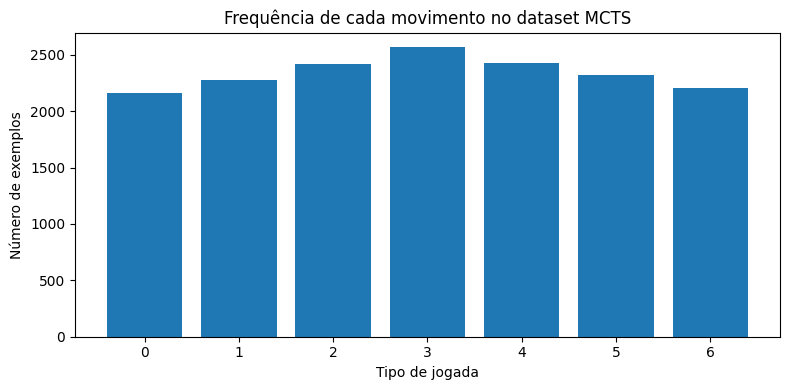

In [48]:
from IPython.display import Image, display
display(Image('content/numeroJogadas.png'))

*Figura 1: Frequência de cada jogada no dataset mcts_dataset.csv*

- É possível ver que o MCTS tende a escolher muito mais as colunas centrais do tabuleiro. Em particular, a coluna 3 (o centro absoluto) responde por cerca de 25–30 % de todas as jogadas geradas, seguida pelas colunas 2 e 4 com ~15–20 % cada. Já as colunas de borda (0 e 6) aparecem em menos de 5 % dos exemplos.

- Reflete uma estratégia clássica de Connect-Four: controlar o centro maximiza o número de linhas de quatro possíveis e permite maior flexibilidade tática. 

- No entanto, esse desequilíbrio no dataset pode causar um viés no modelo ID3, que vai aprender muito bem a classe “3” mas terá menos amostras para diferenciar adequadamente as jogadas de borda.

- Como consequência, a acurácia do ID3 estará inflada se medida apenas globalmente (pois grande parte das previsões recai sobre as colunas centrais).

- Para mitigar essa assimetria, poderíamos aplicar técnicas de re-amostragem (undersampling das classes centrais ou oversampling das extremas) ou class weighting ao treinar a árvore, de modo a equilibrar melhor o aprendizado entre todos os tipos de jogada.

#### 5.3. Impacto de alpha 

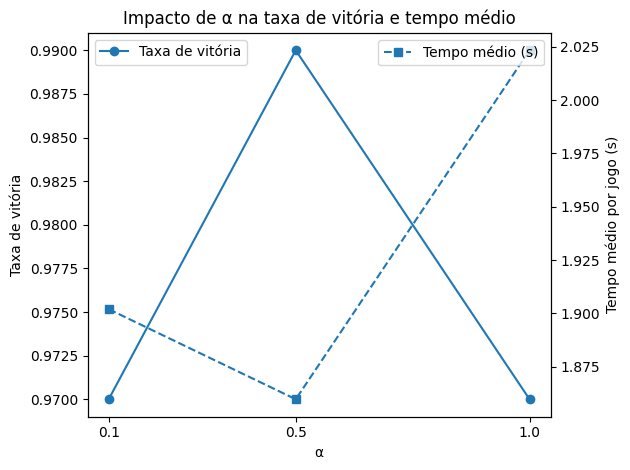

In [49]:
from IPython.display import Image, display
display(Image('content/impactoAlpha.png'))

*Figura 2: Impacto de alpha na taxa de vitória e tempo médio de decisão.*

1. `Ponto ótimo em α = 0.5`
- Maior taxa de vitória (99 %) e menor tempo por jogada (~1.86 s).
- É aí que a exploração vs. exploit está mais equilibrada para o setup usado: explora o suficiente para ver novas jogadas, mas sem dispersar demasiado o esforço de simulação.
2. `Comportamento em α = 0.1`
- Mais "exploitation" na fórmula UCT (α baixo) dá quase o mesmo “sucesso” (97 %) mas leva um pouco mais de tempo (1.90 s).
- Provavelmente o agente está a desperdiçar algumas simulações em ramos menos promissores.
3. `Comportamento em α = 1.0`
- Total foco em "exploration" (α alto) aumenta a velocidade (2.02 s) e faz a taxa de vitória cair para 97 %.
- Quando exploras demais sem peso para a parte de “exploitation”, a árvore não aprofunda rápido nas jogadas que já sabem ser boas.

Conclui-se que α ≃ 0.5 parece ser o “sweet spot” para o MCTS face ao adversário.

#### 5.4. Forças e limitações do algoritmo Monte Carlo Tree Search (MCTS)

- `Vantagens`: adaptável a diferentes jogos, bom trade‑off exploit vs explore; não requer função de avaliação manual;

- `Limitações`: alto custo computacional, potencial para heurísticas pobres em horizontes de busca muito longos.

#### 5.5. Relação entre acurácia e profundidade da árvore usando o algoritmo ID3

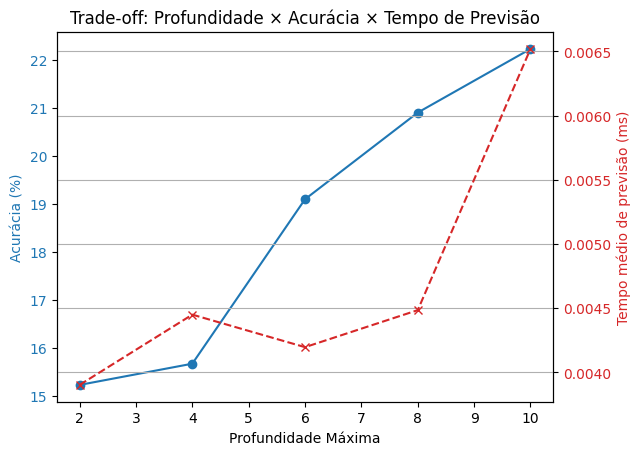

In [64]:
from IPython.display import Image, display
display(Image('content/acuráciaxprofundidadextempo.png'))

*Figura 3. Acurácia da árvore ID3 em função da profundidade e do tempo de previsão.*

- `Tendência geral de melhoria:` A acurácia sobe de 15,23 % (depth 2) para 22,23 % (depth 10), e o tempo médio de previsão mantém-se em ≈ 0,004 ms até profundidade 8, saltando para 0,007 ms em depth 10. Isso mostra que árvores mais profundas capturam mais padrões do dataset, elevando a precisão ao mesmo tempo que aumentam o custo computacional em níveis mais altos de profundidade.
- `Baixa performance em profundidades rasas (2–4):` Em depth 2 e 4, a acurácia é apenas ≈ 15 %, claro sintoma de underfitting — o modelo é demasiado simples para as relações do conjunto. O tempo médio de previsão é mínimo e idêntico nesses dois casos (≈ 0,004 ms), refletindo a estrutura pouco profunda.
- `Grande salto de 4 para 6:` Passar de depth 4 (15,67 %) para 6 (19,10 %) traz um ganho de ≈ 3,4 %, indicando que a árvore começa a capturar interações antes ignoradas. O tempo médio mantém-se em ≈ 0,004 ms, sugerindo que até essa profundidade a complexidade extra não impacta significativamente a latência de inferência.
- `Possível ponto de equilíbrio (“sweet spot”):` Embora a acurácia máxima ocorra em depth 10, o equilíbrio entre ganho de precisão e consistência do tempo de predição pode favorecer profundidades entre 6 e 8.
- `Melhor profundidade (maior acurácia):` Depth 10: acurácia = 22,23 %, tempo médio ≈ 0,007 ms.

#### 5.6. Forças e limitações do algoritmo Iterative Dichotomiser 3 (ID3)

- `Vantagens`: interpretabilidade, rapidez de predição;

- `Limitações`: baixa robustez em cenários de alta dimensionalidade / características contínuas sem discretização cuidadosa.

#### 5.7. Comparação Geral

| Critério          | ID3 (Árvore de Decisão) | MCTS                 |
| ----------------- | ----------------------- | -------------------- |
| Tipo de algoritmo | Supervisionado (aprende com os dados)| Não supervisionado (baseado em simulação) |   
| Treino            | Necessita de dataset    | Nada                 |
| Capacidade de generalização     | Limitada aos padrões nos dados| Explora os estados dinamicamente|
| Desempenho tático | Previsível e frágil     | Adapta-se            |
| Velocidade de Decisão   | Muito rápida (árvore já construída) | Mais lenta (requer simulações)|
| Complexidade Computacional    | Baixa depois de treinada       | Alta (depende de nr de simulações)  |

- `Cenários simples (board estável, poucos movimentos)`: ID3 pode competir razoavelmente bem;

- `Cenários complexos (alto branching factor)`: MCTS tende a superar.

Conclui-se que:
- O ID3 é útil para demonstrar como a IA pode tomar decisões com base em exemplos passados, mas não reage bem a situações fora do padrão;
- O MCTS é mais robusto, adaptável e inteligente em tempo real, especialmente quando configurado com um número razoável de simulações e bom ajuste do coeficiente de exploração.

#### 5.8. Sugestões de Extensões Futuras

- Implementar poda em ID3 (e.g. reduced error pruning);

- Comparar com outros algoritmos de decisão (e.g. Random Forest, XGBoost);

## 6. Conclusão 

Neste trabalho, explorámos duas abordagens distintas de Inteligência Artificial aplicadas ao jogo Connect Four: Monte Carlo Tree Search (MCTS) e Árvores de Decisão (ID3). 

O MCTS demonstrou ser significativamente mais eficaz. Ao simular milhares de partidas possíveis antes de tomar decisões, esta abordagem conseguiu adaptar-se melhor ao adversário e ao estado atual do jogo. O uso de parâmetros como o número de simulações e o coeficiente de exploração (com ajuste via `alpha`) mostrou-se crucial para alcançar um bom desempenho.

Por outro lado, a árvore de decisão, treinada com exemplos de jogadas rotuladas, revelou-se uma solução rápida e compreensível, ideal para situações em que há padrões bem definidos. No entanto, a sua limitação torna-se evidente em jogos com muitas possibilidades ou situações novas não presentes no conjunto de treino.

Concluímos que, embora o ID3 seja uma boa introdução a modelos supervisionados, o MCTS é a abordagem mais recomendada para jogos com alto número de estados e onde a tomada de decisão precisa ser dinâmica e exploratória. O projeto mostrou na prática como diferentes paradigmas de IA têm pontos fortes em contextos distintos.

## 7. Referências

- Qi Wang’s Blog! (2022). Connect 4 with Monte Carlo Tree Search. [online] Available at: https://www.harrycodes.com/blog/monte-carlo-tree-search;

- matant (2020). Monte Carlo Tree Search - ConnectX. [online] Kaggle.com. Available at: https://www.kaggle.com/code/matant/monte-carlo-tree-search-connectx;
‌
- ‌OpenAI (2025). ChatGPT. [online] chatgpt.com. Available at: https://chatgpt.com;
‌
- GeeksforGeeks. (2024). Iterative Dichotomiser 3 (ID3) Algorithm From Scratch. [online] Available at: https://www.geeksforgeeks.org/iterative-dichotomiser-3-id3-algorithm-from-scratch/;
‌
- AshirbadPradhan (2023). Decision Tree ID3 Algorithm |Machine Learning. [online] Medium. Available at: https://medium.com/@ashirbadpradhan8115/decision-tree-id3-algorithm-machine-learning-4120d8ba013b.
‌